In [54]:
import numpy as np
import gradio as gr
import cv2
import os
import matplotlib.pyplot as plt
from efficient_sam.build_efficient_sam import build_efficient_sam_vitt, build_efficient_sam_vits # type: ignore
from PIL import Image
from torchvision import transforms
import torch
import zipfile

# 定義點的顏色和標記器
colors = [(255, 0, 0), (0, 255, 0)]
markers = [1, 5]

# 圖片示例
image_examples = [
    [os.path.join(r"C:\Users\USER\Desktop\LAO\git\mask_sam\images\images\images.jpg"), 2, []],
]

# 創建界面
with gr.Blocks() as demo:
    with gr.Row():
        gr.Markdown('''# 好難喔''')
    with gr.Tab(label='Image'):
        with gr.Row():
            with gr.Column():
                # 原始圖像
                original_image = gr.State(value=None)   # 存儲沒有點的原始圖像，默認為None
                input_image = gr.Image(type="numpy")
                # 點提示
                with gr.Column():
                    selected_points = gr.State([])  
                    print("selected_points ",selected_points.value)   
                # 執行按鈕
                delete_button = gr.Button("delete!!")
                radio = gr.Radio(['foreground_point', 'background_point'], label='point labels')
            with gr.Row():
                # select model
                model_type = gr.Dropdown(["vit_s", "vit_t"], value='vit_s', label="Select Model")
                # select device
                device = gr.Dropdown(["cpu", "cuda"], value='cpu', label="Select Device")

            # 顯示帶有蒙版的圖像
            with gr.Tab(label='Image+Mask'):
                output_image_mask = gr.Image(type='numpy')
            with gr.Tab(label='Image'):
                output_image = gr.Image(type='numpy')
            # 只顯示蒙版
            with gr.Tab(label='Mask'):
                output_mask = gr.Image(type='numpy')
            # run button
            button = gr.Button("開始!")
            

        def process_example(img, ori_img, sel_p):
            return ori_img, []

        example = gr.Examples(
            examples=image_examples,
            inputs=[input_image, original_image, selected_points],
            outputs=[original_image, selected_points],
	        fn=process_example,
	        run_on_click=True
        )
    ########################################
    def store_img(img):
        # 上傳圖片
        print("image.upload")
        return img, []  # when new image is uploaded, `selected_points` should be empty
    input_image.upload(
        store_img,
        [input_image],
        [original_image, selected_points]
    )
    ########################################
    # 當用戶點擊圖片時，獲取點的位置並在圖片上顯示點
    def get_point(img, sel_pix, point_type, evt: gr.SelectData):
        if point_type == 'foreground_point':
            sel_pix.append((evt.index, 1))   # append the foreground_point
        elif point_type == 'background_point':
            sel_pix.append((evt.index, 0))    # append the background_point
        else:
            sel_pix.append((evt.index, 1))    # default foreground_point
        print(sel_pix)
        # 繪製點
        
        for point,label in sel_pix:
            cv2.drawMarker(img, point, colors[label], markerType=markers[label], markerSize=20, thickness=5)
        if img[..., 0][0, 0] == img[..., 2][0, 0]:  # BGR 轉 RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img if isinstance(img, np.ndarray) else np.array(img)
    
    input_image.select(
        get_point,
        [input_image,selected_points, radio],
        [input_image],
    )
    ########################################

    def delete_points(orig_img, sel_pix):
        if isinstance(orig_img, int):   # 如果 orig_img 是整數，則圖像來自示例
            temp = cv2.imread(image_examples[orig_img][0])
            temp = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)
        else:
            temp = orig_img.copy()
        # 繪製點
        if len(sel_pix) != 0:
            sel_pix.pop()  # 刪除最後一個元素
            for point, label in sel_pix:
                cv2.drawMarker(temp, point, colors[label], markerType=markers[label], markerSize=20, thickness=5)
        if temp[..., 0][0, 0] == temp[..., 2][0, 0]:  # BGR 轉 RGB
            temp = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)
        return temp if isinstance(temp, np.ndarray) else np.array(temp)
    
    delete_button.click(
        delete_points,
        [original_image, selected_points],
        [input_image]
    )
##################################################

    def main(model_type, selected_points, original_image):
        models = {}
        points_append=[]
        labels_append=[]
        print("----train----")
        sample_image_tensor = transforms.ToTensor()(original_image)
        
        if model_type == "vit_s":
                models['efficientsam_ti'] = build_efficient_sam_vits()
        else:
                models['efficientsam_ti'] = build_efficient_sam_vitt()
        for _, labels in selected_points:
            labels_append.append(labels)
        clicked_points = [[[point[0], point[1]] for point, _ in selected_points]]
    
        input_points = torch.tensor([clicked_points])
        input_labels = torch.tensor([[labels_append]])
        print("input_points ",input_points)
        print("input_labels ",input_labels)
        masked_images = []
        for model_name, model in models.items():
            print('Running inference using ', model_name)
            predicted_logits, predicted_iou = model(
                sample_image_tensor[None, ...],
                input_points,
                input_labels,
            )
            sorted_ids = torch.argsort(predicted_iou, dim=-1, descending=True)
            predicted_iou = torch.take_along_dim(predicted_iou, sorted_ids, dim=2)
            predicted_logits = torch.take_along_dim(
                predicted_logits, sorted_ids[..., None, None], dim=2
            )
            mask = torch.ge(predicted_logits[0, 0, 0, :, :], 0).cpu().detach().numpy()
            masked_image_np = original_image.copy().astype(np.uint8) * mask[:,:,None]

            mask_data = mask.astype(np.uint8) * 255
            # 使用 PIL 創建圖像
            mask_image = Image.fromarray(mask_data)
        #############################################
        def prepare_input(input_image, points, labels, torch_tensor=True):
            img_tensor = np.ascontiguousarray(input_image)[None, ...].astype(np.float32) / 255
            img_tensor = np.transpose(img_tensor, (0, 3, 1, 2))
            pts_sampled = np.reshape(np.ascontiguousarray(points), [1, 1, -1, 2])
            pts_labels = np.reshape(np.ascontiguousarray(labels), [1, 1, -1])
            if torch_tensor:
                img_tensor = torch.from_numpy(img_tensor)
                pts_sampled = torch.from_numpy(pts_sampled)
                pts_labels = torch.from_numpy(pts_labels)
            return img_tensor, pts_sampled, pts_labels
        def postprocess_results(predicted_iou, predicted_logits):
            sorted_ids = np.argsort(-predicted_iou, axis=-1)
            predicted_iou = np.take_along_axis(predicted_iou, sorted_ids, axis=2)
            predicted_logits = np.take_along_axis(
                predicted_logits, sorted_ids[..., None, None], axis=2
            )
            return predicted_logits[0, 0, 0, :, :] >= 0
        def addAnnotation(img,mask):
            # 将灰度遮罩转换为BGR格式，并设置为红色
            red_mask = np.zeros_like(img)
            red_mask[mask != 0] = [0, 0, 255]  # 将遮罩区域设置为红色

            # 将遮罩区域与原始图像合并
            masked_image = cv2.addWeighted(img, 1, red_mask, 1, 0)
            cv2.imwrite(r"C:\Users\USER\Pictures\masked_image.jpg", masked_image)
            cv2.imwrite(r"C:\Users\USER\Pictures\masked_image2.jpg", img)
            # cv2.imwrite(r"C:\Users\USER\Pictures\masked_image3.jpg", mask)
            return masked_image
        
        for model_name, model in models.items():
            print('Running inference using ', model_name)
            predicted_logits, predicted_iou = model(
                sample_image_tensor[None, ...],
                input_points,
                input_labels,
            )

        predicted_mask = postprocess_results(predicted_iou.detach().numpy(), predicted_logits.detach().numpy())
        masked_image = np.copy(original_image)
        masked_image[mask != 0] = [255, 0, 0]  # 这里假设将掩码部分标记为红色
        
        img=addAnnotation(original_image,mask)
        return masked_image_np,mask_image,img


    button.click(main, inputs=[model_type, selected_points, original_image], 
                 outputs=[output_image,output_mask,output_image_mask])
demo.launch()

selected_points  []
Running on local URL:  http://127.0.0.1:7880

To create a public link, set `share=True` in `launch()`.


image.upload
[([199, 144], 1)]
----train----
input_points  tensor([[[[199, 144]]]])
input_labels  tensor([[[1]]])
Running inference using  efficientsam_ti
Running inference using  efficientsam_ti


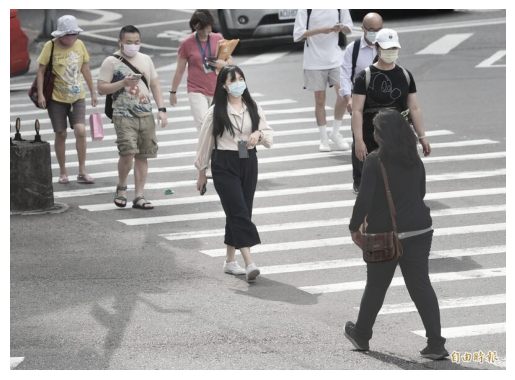

In [43]:
%matplotlib inline

import cv2

import matplotlib.pyplot as plt
# 讀取圖像和遮罩
image = cv2.imread(r'C:\Users\USER\Pictures\input.jpg')
mask = cv2.imread(r'C:\Users\USER\Pictures\image2.png', cv2.IMREAD_GRAYSCALE)


# 確保遮罩和圖像大小相同
mask = cv2.resize(mask, (image.shape[1], image.shape[0]))

# 設置透明度
alpha = 0.5  # 透明度 0.0 ~ 1.0

# 將遮罩應用到圖像上
masked_image = cv2.addWeighted(image, 1 - alpha, cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR), alpha, 0)
# 显示图像
plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
plt.axis('off')  # 关闭坐标轴
plt.show()



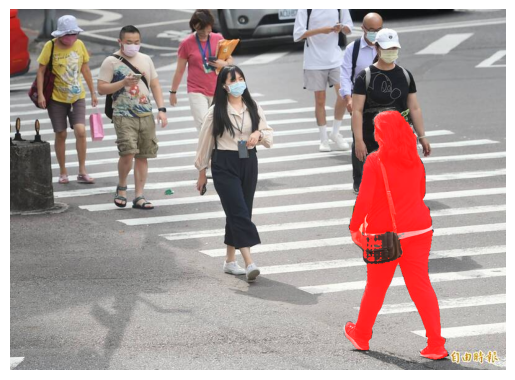

In [47]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 读取图像和遮罩
image = cv2.imread(r'C:\Users\USER\Pictures\input.jpg')
mask = cv2.imread(r'C:\Users\USER\Pictures\image1.png', cv2.IMREAD_GRAYSCALE)

# 将灰度遮罩转换为BGR格式，并设置为红色
red_mask = np.zeros_like(image)
red_mask[mask != 0] = [0, 0, 255]  # 将遮罩区域设置为红色

# 将遮罩区域与原始图像合并
masked_image = cv2.addWeighted(image, 1, red_mask, 1, 0)

# 显示图像
plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
plt.axis('off')  # 关闭坐标轴
plt.show()


In [3]:
import torch
device_compute = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device_compute.type

'cuda'